In [2]:
import pandas as pd

# Load training data
train_path = "/content/twitter_training.csv"
val_path = "/content/twitter_validation.csv"

# These files do not have headers, so we add column names
cols = ["tweet_id", "entity", "sentiment", "text"]

train_df = pd.read_csv(train_path, names=cols)
val_df = pd.read_csv(val_path, names=cols)

# Show first few rows
train_df.head()


,tweet_id,entity,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [3]:
print(train_df.info())
print(train_df['sentiment'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   74682 non-null  int64 
 1   entity     74682 non-null  object
 2   sentiment  74682 non-null  object
 3   text       73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB
None
sentiment
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64


In [5]:
# Drop rows where text is missing
train_df = train_df.dropna(subset=['text'])
val_df = val_df.dropna(subset=['text'])

# Apply text cleaning
train_df['clean_text'] = train_df['text'].apply(clean_text)
val_df['clean_text'] = val_df['text'].apply(clean_text)


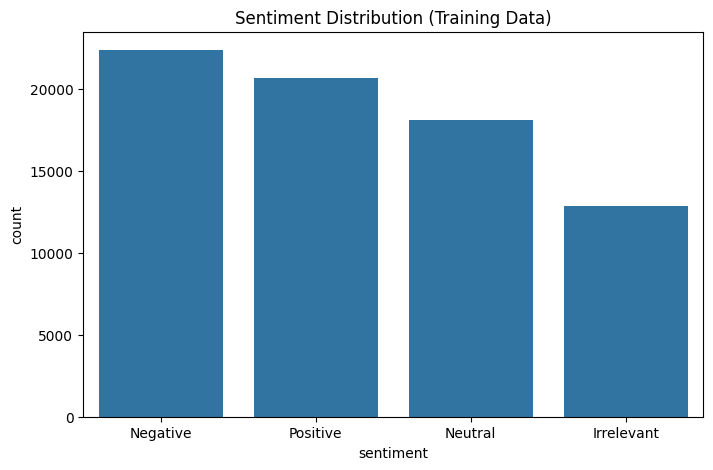

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.countplot(data=train_df, x='sentiment', order=train_df['sentiment'].value_counts().index)
plt.title("Sentiment Distribution (Training Data)")
plt.show()


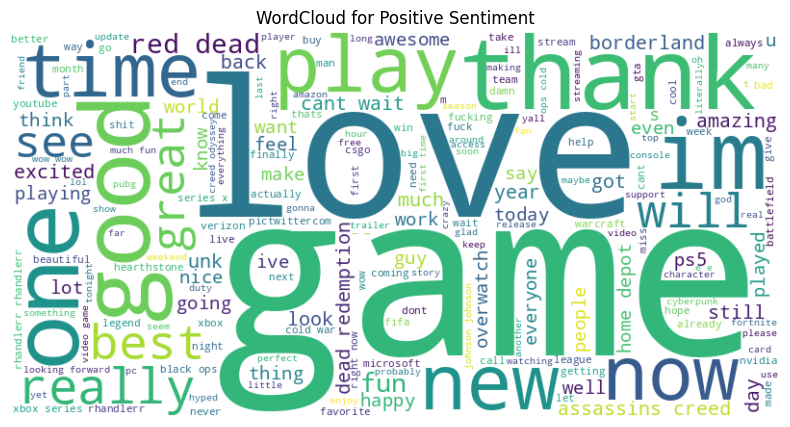

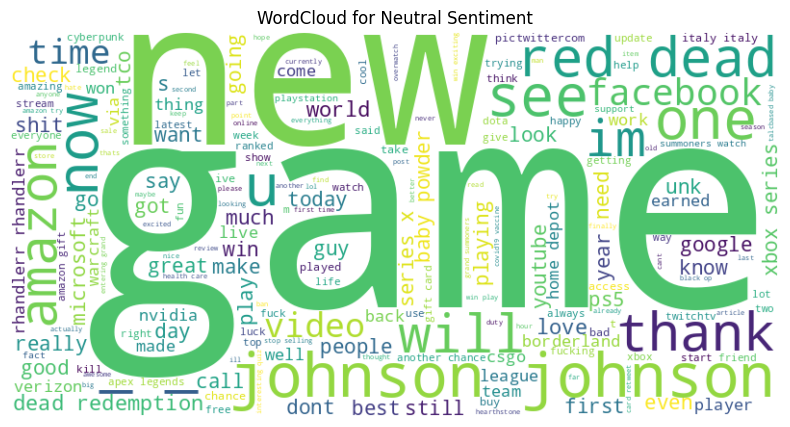

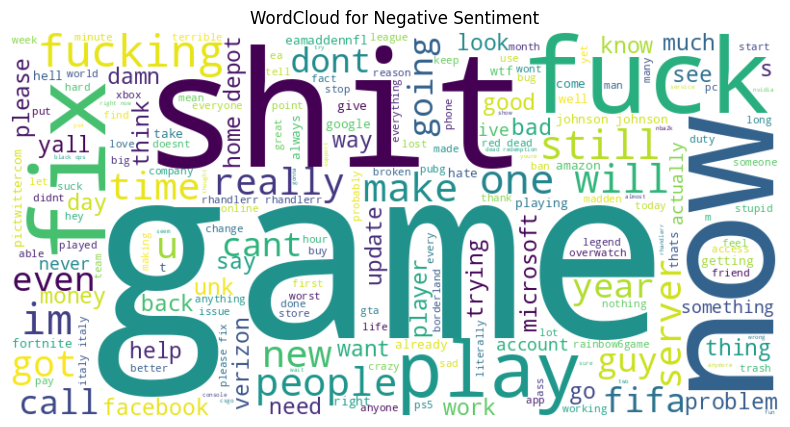

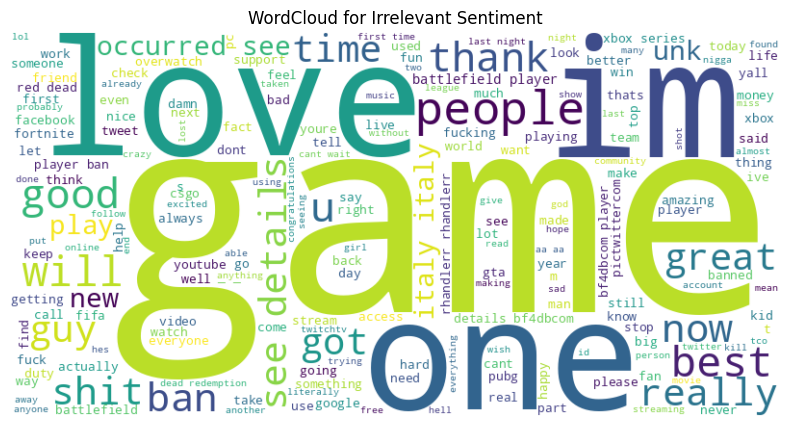

In [7]:
from wordcloud import WordCloud

for sentiment in train_df['sentiment'].unique():
    text = " ".join(train_df[train_df['sentiment'] == sentiment]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud for {sentiment} Sentiment")
    plt.show()


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

X = train_df['clean_text']
y = train_df['sentiment']

# Vectorize
vectorizer = CountVectorizer()
X_vec = vectorizer.fit_transform(X)

# Split train/validation
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

# Train
model = MultinomialNB()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.7263513513513513
              precision    recall  f1-score   support

  Irrelevant       0.82      0.55      0.66      2696
    Negative       0.69      0.85      0.76      4380
     Neutral       0.81      0.60      0.69      3605
    Positive       0.69      0.81      0.75      4119

    accuracy                           0.73     14800
   macro avg       0.75      0.71      0.71     14800
weighted avg       0.74      0.73      0.72     14800



In [9]:
X_val = vectorizer.transform(val_df['clean_text'])
val_preds = model.predict(X_val)

val_df['predicted_sentiment'] = val_preds
val_df[['entity', 'text', 'sentiment', 'predicted_sentiment']].head()


,entity,text,sentiment,predicted_sentiment
0,Facebook,I mentioned on Facebook that I was struggling ...,Irrelevant,Irrelevant
1,Amazon,BBC News - Amazon boss Jeff Bezos rejects clai...,Neutral,Neutral
2,Microsoft,@Microsoft Why do I pay for WORD when it funct...,Negative,Negative
3,CS-GO,"CSGO matchmaking is so full of closet hacking,...",Negative,Negative
4,Google,Now the President is slapping Americans in the...,Neutral,Neutral


In [10]:
import plotly.express as px

sentiment_counts = train_df['sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['sentiment', 'count']

fig = px.pie(sentiment_counts, names='sentiment', values='count', title='Sentiment Distribution')
fig.show()
